In [4]:
# import torch
# torch_version = torch.__version__.split('+')[0]  # e.g., '2.1.0'
# url = f"https://data.pyg.org/whl/torch-{torch_version}.html"

# Now install with pip
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f {url}


Looking in links: https://data.pyg.org/whl/torch-2.6.0.html


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Using cached torch_scatter-2.1.2-cp310-cp310-win_amd64.whl
  Using cached torch_sparse-0.6.18-cp310-cp310-win_amd64.whl
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached aiohttp-3.11.14-cp310-cp310-win_amd64.whl (442 kB)
  Using cached yarl-1.18.3-cp310-cp310-win_amd64.whl (90 kB)
  Using cached frozenlist-1.5.0-cp310-cp310-win_amd64.whl (51 kB)
  Using cached propcache-0.3.0-cp310-cp310-win_amd64.whl (44 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
  Using cached multidict-6.2.0-cp310-cp310-win_amd64.whl (29 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
import os

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.neighbors import kneighbors_graph


In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)

seedEverything(2021)

In [3]:
# url = "https://raw.githubusercontent.com/akashvenus/Final_Project/refs/heads/main/sets1/train.csv"
df = pd.read_csv("combined_train_df.csv")
df

,Unnamed: 0,destination port,flow duration,total fwd packets,total backward packets,total length of fwd packets,total length of bwd packets,fwd packet length max,fwd packet length min,fwd packet length mean,...,min_seg_size_forward,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min,label
0,0,53,102919,4,4,164,408,41,41,41.000000,...,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,BENIGN
1,1,53,30727,4,2,136,182,34,34,34.000000,...,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,BENIGN
2,2,53,31080,2,2,84,204,42,42,42.000000,...,32,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,BENIGN
3,3,53,108170,1,1,48,190,48,48,48.000000,...,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,BENIGN
4,4,80,85434190,6,6,330,11595,312,0,55.000000,...,20,11000.000000,0.000000,11000,11000,8.520000e+07,0.000000,85200000,85200000,DoS Hulk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95308,95308,55,162455,1,1,74,0,53,49,42.864010,...,-486,525.250852,76.138399,0,0,6.060012e+04,2758.980544,0,10139,BENIGN
95309,95309,76,6968030,3,0,0,0,7,0,1.382082,...,-173,0.000000,0.000000,0,307,3.306024e+04,6916.584822,0,7797,Web Attack � XSS
95310,95310,52687,175965,4,4,1916,868,48,0,152.240727,...,93,1463.118672,31.252395,0,581,2.648540e+04,2310.211206,0,55424,BENIGN
95311,95311,72,-4,2,1,18,1232,2,0,0.000000,...,-842,0.000000,0.000000,0,0,2.072905e+04,1476.562843,0,0,Web Attack � Sql Injection


In [4]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
import joblib

scaler = joblib.load("scaler.pkl")

Loading saved scaler which is used by baseline for scaling the data

In [7]:
X = df[scaler.feature_names_in_]
y = df['label'].values
num_nodes = len(df)

In [8]:
X_scaled = scaler.transform(X)

In [9]:
train_idx_np, test_idx_np = train_test_split(
    np.arange(num_nodes),
    test_size=0.33,
    stratify=y,
    random_state=DEFAULT_RANDOM_SEED
)

In [10]:
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx_np] = True

In [11]:
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_idx_np] = True

In [23]:
k = 5
knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, include_self=False)

row_idx, col_idx = knn_graph.nonzero()
edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)

# Convert to PyG data
x = torch.tensor(X_scaled, dtype=torch.float)
y_torch = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y_torch)
print(data)

Data(x=[95313, 78], edge_index=[2, 476565], y=[95313])


In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels, dropout=0.1):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)
        
        self.dropout = nn.Dropout(p=dropout)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.dropout(x) 

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

model = GraphNet(
    in_channels=x.shape[1],  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2,           # final classes (0=Benign, 1=Attack)
    dropout=0.1
)


loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [21]:
# epochs = 80
# for epoch in range(1, epochs+1):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data.x, data.edge_index)  # shape: [num_nodes, 2]

#     # Compute loss on train_mask only
#     loss = loss_fn(out[train_mask], data.y[train_mask])
#     loss.backward()
#     optimizer.step()

#     # Evaluate on test set
#     if epoch % 10 == 0 or epoch == epochs:
#         model.eval()
#         with torch.no_grad():
#             out_test = out[test_mask]
#             pred_test = out_test.argmax(dim=1)
#             y_true_test = data.y[test_mask]

#             acc = accuracy_score(y_true_test.cpu(), pred_test.cpu())
#             print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f} | Test Accuracy: {acc:.4f}")


Epoch 10/80 | Loss: 0.2274 | Test Accuracy: 0.9052
Epoch 20/80 | Loss: 0.1471 | Test Accuracy: 0.9420
Epoch 30/80 | Loss: 0.1207 | Test Accuracy: 0.9506
Epoch 40/80 | Loss: 0.1022 | Test Accuracy: 0.9560
Epoch 50/80 | Loss: 0.0967 | Test Accuracy: 0.9574
Epoch 60/80 | Loss: 0.0850 | Test Accuracy: 0.9642
Epoch 70/80 | Loss: 0.0775 | Test Accuracy: 0.9675
Epoch 80/80 | Loss: 0.0714 | Test Accuracy: 0.9708


In [26]:
best_loss = float('inf')
patience = 10  # Number of epochs to wait before stopping
counter = 0
epochs = 80

for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = loss_fn(val_out[test_mask], data.y[test_mask])

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0  # Reset counter if validation improves
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

In [27]:
model.eval()
with torch.no_grad():
    out_all = model(data.x, data.edge_index)
    pred_all = out_all.argmax(dim=1)

    # Evaluate on test_mask
    y_true_test = data.y[test_mask]
    y_pred_test = pred_all[test_mask]

    # Basic metrics
    acc_test  = accuracy_score(y_true_test.cpu(), y_pred_test.cpu())
    prec_test = precision_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')
    rec_test  = recall_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')
    f1_test   = f1_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')

    tn, fp, fn, tp = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu()).ravel()
    fpr_test = fp / (fp + tn)

    print("\nFinal Test Metrics (Node-Level Classification):")
    print("-----------------------------------------------")
    print(f"Accuracy:    {acc_test:.4f}")
    print(f"Precision:   {prec_test:.4f}")
    print(f"Recall:      {rec_test:.4f}")
    print(f"F1-Score:    {f1_test:.4f}")
    print(f"False Pos Rate (FPR): {fpr_test:.4f}")
    print(classification_report(y_true_test.cpu(), y_pred_test.cpu(), target_names=['Benign (0)', 'Attack (1)']))


Final Test Metrics (Node-Level Classification):
-----------------------------------------------
Accuracy:    0.9726
Precision:   0.9406
Recall:      0.9598
F1-Score:    0.9501
False Pos Rate (FPR): 0.0226
              precision    recall  f1-score   support

  Benign (0)       0.98      0.98      0.98     22915
  Attack (1)       0.94      0.96      0.95      8539

    accuracy                           0.97     31454
   macro avg       0.96      0.97      0.97     31454
weighted avg       0.97      0.97      0.97     31454



The GNN + DNN model is trained and tested and output is displayed

In [28]:
torch.save(model.state_dict(), "GNN_DNN_weights.pth")

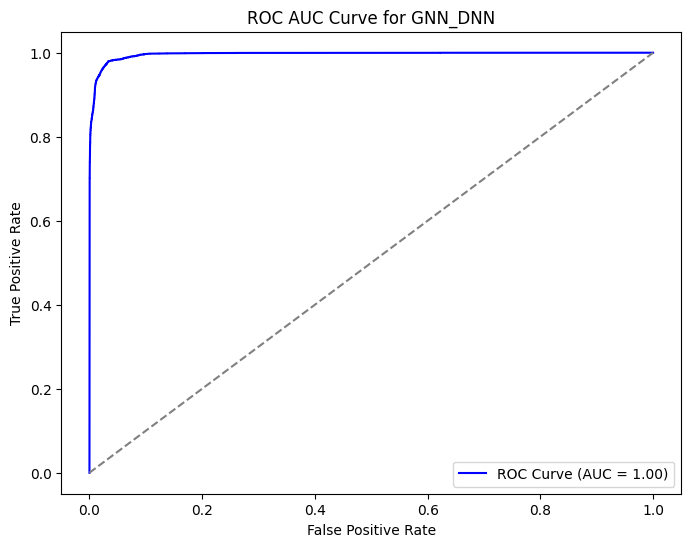

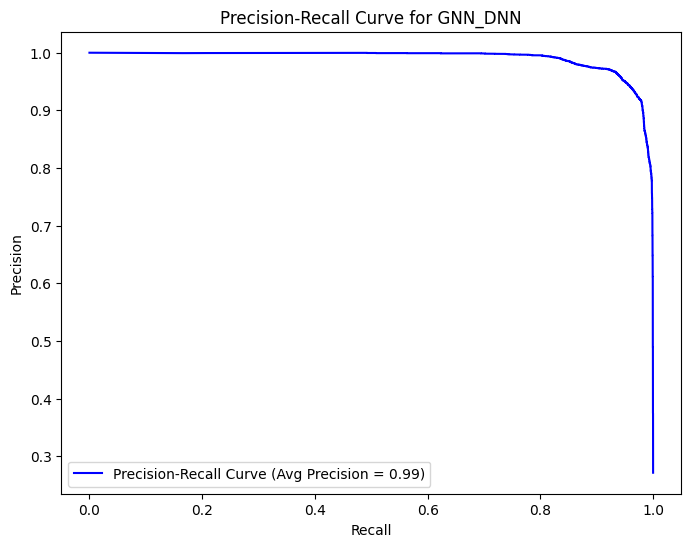

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc,  average_precision_score

model_name = "GNN_DNN"

with torch.no_grad():
    out_prob = out_all.exp()               # Convert from log-probs to probabilities
    y_proba_test = out_prob[test_mask, 1]  # Probability of class=1 for test nodes

# Convert to numpy arrays
y_true_test_np = y_true_test.cpu().numpy()
y_proba_test_np = y_proba_test.cpu().numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test_np, y_proba_test_np)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve for {model_name}')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_test_np, y_proba_test_np)
avg_precision = average_precision_score(y_true_test_np, y_proba_test_np)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue',
         label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {model_name}')
plt.legend(loc='lower left')
plt.show()

Plotted only to see if the model is overfitting or not